# Propagation of Asymmetric waveguide

We think their definitions of radiation mode classes might not diagonalize the integral coefficient system in the case of non-symmetric waveguides.  Here we check.  We did and found a bug in the code.  See other checks section near bottom of notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from slab import SlabExact
from scipy.optimize import newton
from scipy.integrate import quad
plt.style.use('dark_background')
%matplotlib widget

In [63]:
A = SlabExact(Ts=[4, 2, 2, 4], ns=[1.47, 1.5, 1.8, 1.47], xrefs=[400, 200, 200, 400],
              symmetric=True)

## Find guided modes

There is a mode near cutoff for Ts=[4, 2, 2, 4], ns=[1.47, 1.5, 1.8, 1.47] and default wavelength and scalings.

(<Figure size 1100x500 with 2 Axes>, <Axes: >)

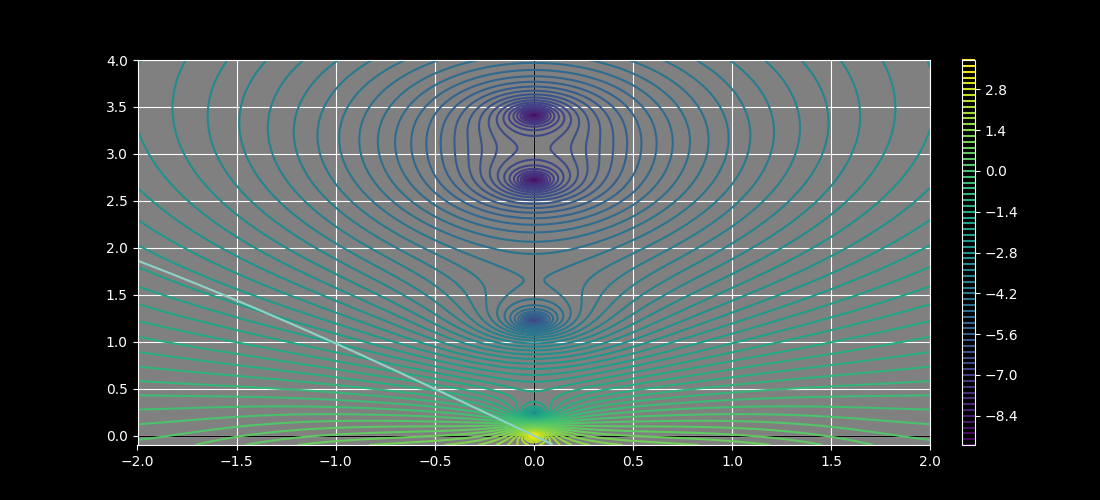

In [64]:
A.determinant_plot(-2, 2, -.1, 4)

In [66]:
guesses = [3.5j, 2.75j, 1.25j, .2j]
Zs_guided = np.array([newton(A.determinant, np.array(guess))[0] for guess in guesses])
A.plot_points(Zs_guided)
F_guided = [A.fields(Z, rounding=10) for Z in Zs_guided]

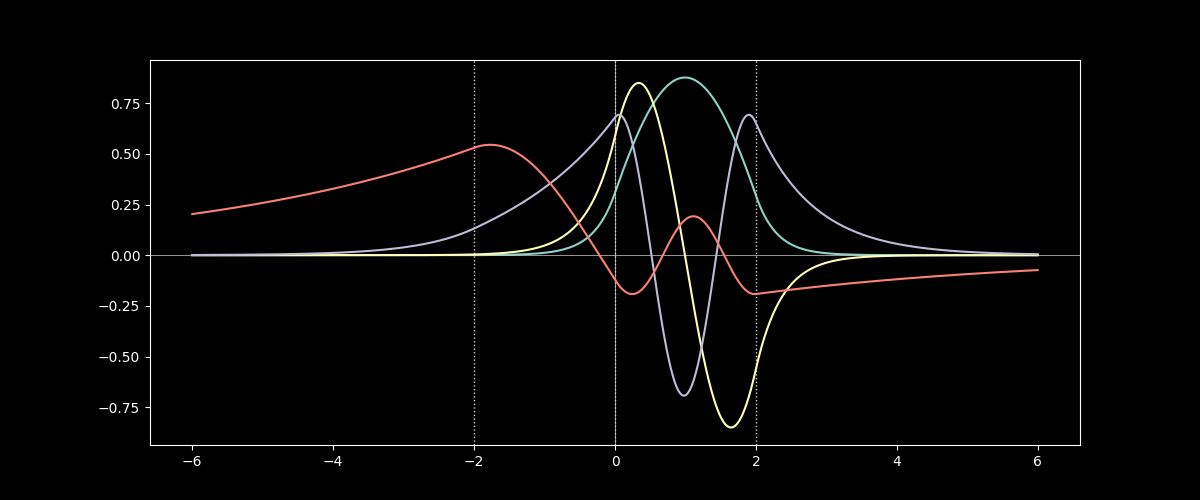

In [67]:
A.plot_field_1d(F_guided[0])
for Fg in F_guided[1:]:
    A.add_1d_plot(Fg)

# Define input functions

In [68]:
w = .5
s = -.05
amp = 2.5

Lx = -w + s
Rx = w + s

def quadratic_piecewise(x):
    conds = [(x<Lx), ((Lx<=x)*(x<=Rx)), (x>Rx)]
    funcs = [0, lambda x: amp * (1 - ((x-s)/w)**2), 0]
    return np.piecewise(x, conds, funcs)
    
def modified_dist(x):
    return (x-1/4) * np.exp(-((x-1/2)/.5)**2)  

def odd_modified_dist(x):
    return x * np.exp(-x**2)
    
def normal_dist(x):
    return np.exp(-x**2)

In [69]:
# Set input function
f0 = quadratic_piecewise

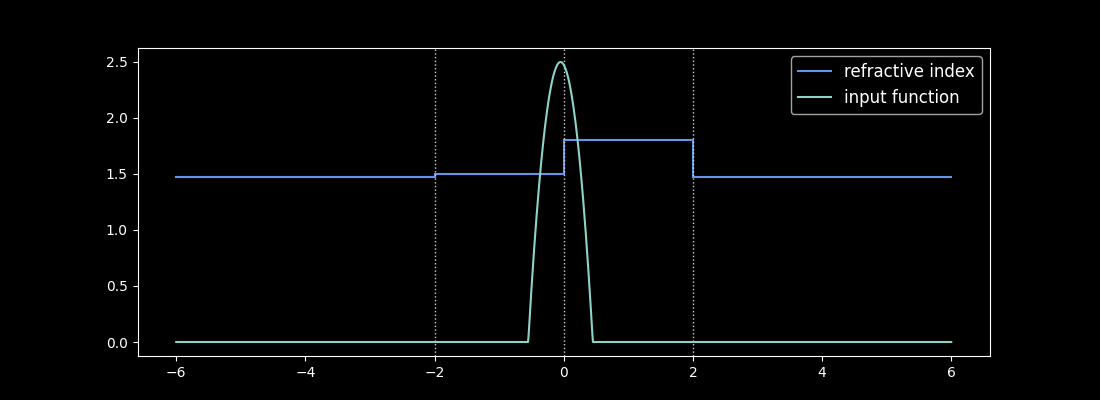

In [70]:
A.plot_refractive_index(part='real', label='refractive index');
A.add_1d_plot(f0, label='input function')

### Guided coefficients

In [71]:
alphas = np.array([quad(lambda x: Fg(x) * f0(x), Lx, Rx, complex_func=True)[0] for Fg in F_guided])


## Visualize Guided Field

In [72]:
guided = lambda x: sum([Fg(x) * alpha for Fg, alpha in zip(F_guided, alphas)])
Guided = lambda x, z : sum([Fg(x, z) * alpha for Fg, alpha in zip(F_guided, alphas)])

In [73]:
mid_xs = np.linspace(-8, 8, 140)

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

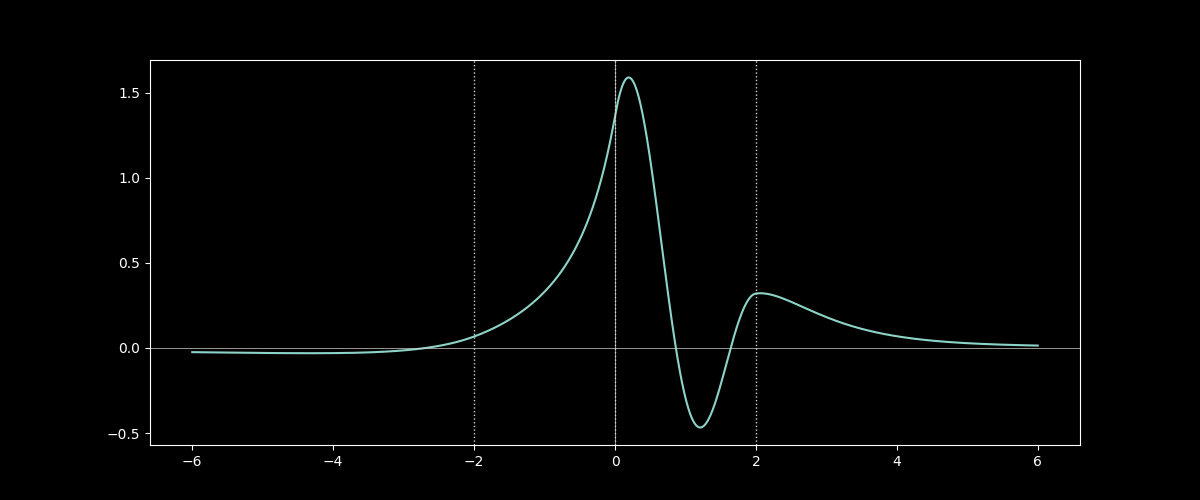

In [74]:
A.plot_field_1d(guided)

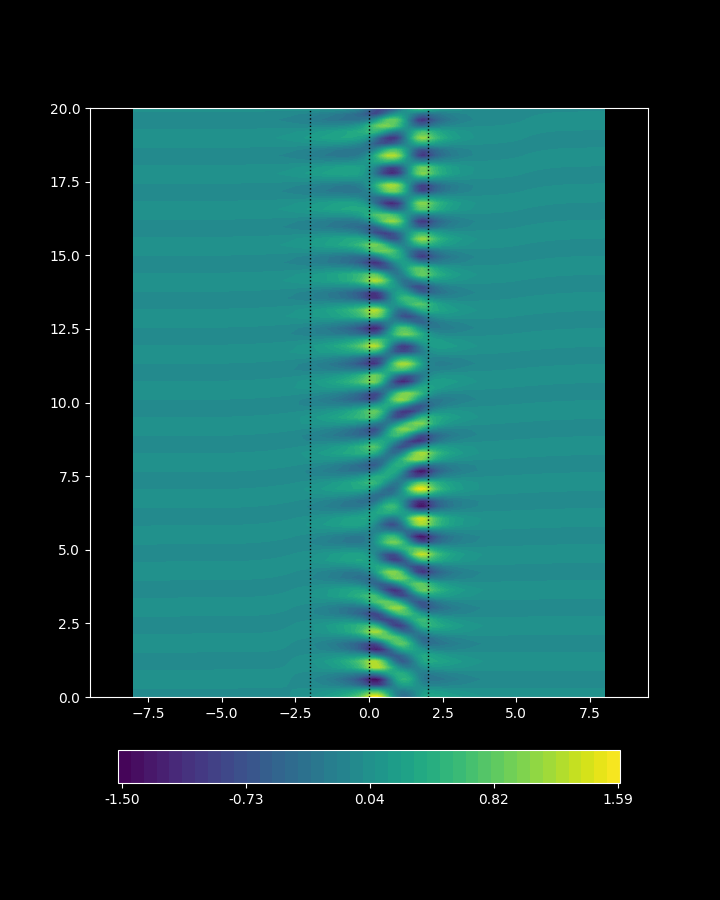

In [75]:
A.plot_field_2d(Guided, xs=mid_xs, zmin=0, zmax=20, zref=100)
plt.axis('equal');

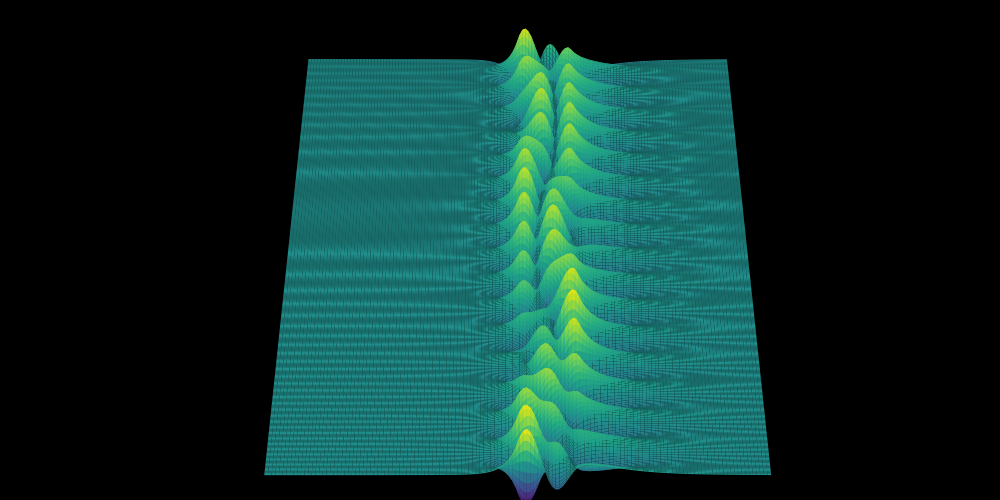

In [48]:
A.plot_field_2d_surface(Guided, xs=mid_xs, zmin=0, zmax=20, zref=400, cstride=1, rstride=1,
                        elev=46);

# Propagate Radiation Field

In [49]:
Propagator_Class = A.propagator()
Eig = A.normalizer('eigvec')
Ours = A.normalizer('ours')

In [50]:
P1e = Propagator_Class(A.real_contour(0.0001, A.Z_evanescent.real, 200),
                       Normalizer=Eig, f0=f0, Lx=Lx, Rx=Rx, sign='+1')

P1o = Propagator_Class(A.real_contour(0.0001, A.Z_evanescent.real, 200),
                       Normalizer=Eig, f0=f0, Lx=Lx, Rx=Rx, sign='-1')

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

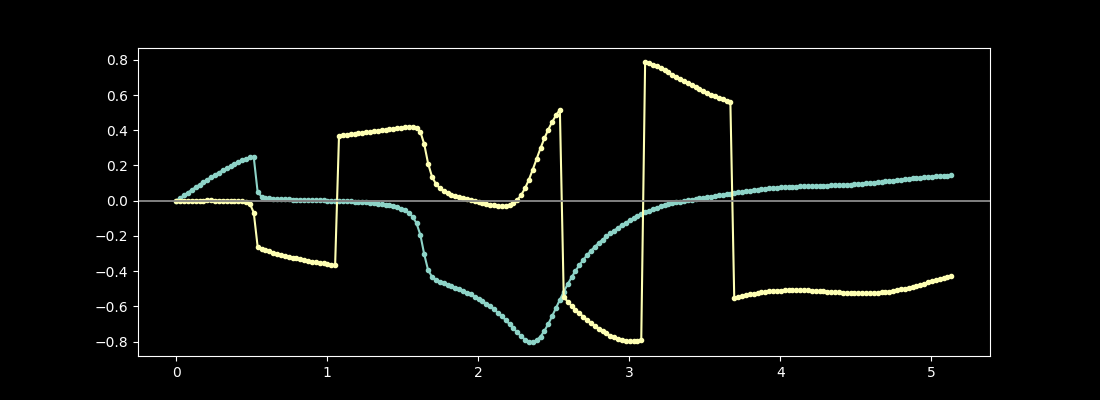

In [51]:
P1e.plot_transform()
P1o.plot_transform(ax=plt.gca())

In [52]:
P2e = Propagator_Class(A.real_contour(A.Z_evanescent.real, 30, 500),
                       Normalizer=Eig, f0=f0, Lx=Lx, Rx=Rx, sign='+1')
P2o = Propagator_Class(A.real_contour(A.Z_evanescent.real, 30, 500),
                       Normalizer=Eig, f0=f0, Lx=Lx, Rx=Rx, sign='-1')

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

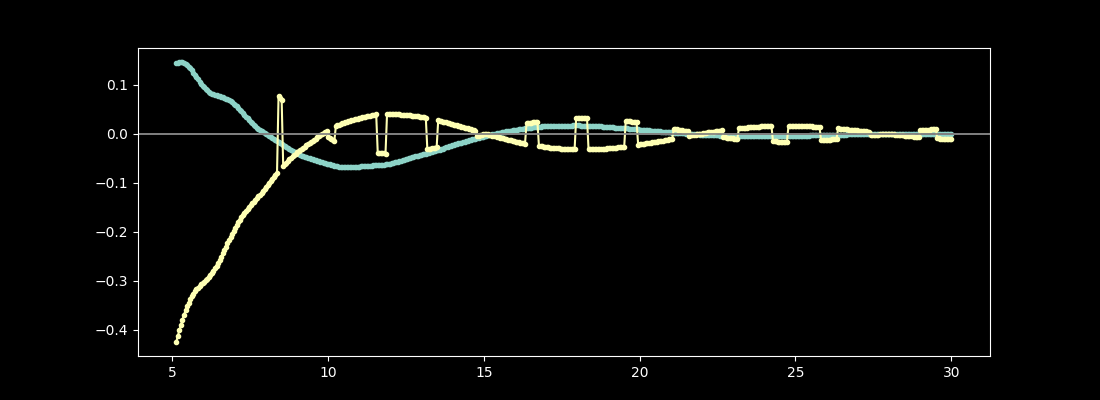

In [53]:
P2e.plot_transform()
P2o.plot_transform(ax=plt.gca())

### Combine propagators into one function

In [54]:
P_prop = [P1e,
          P1o,
         ]

P_ev = [P2e,
        P2o,
       ]


prop = lambda x: sum([P.slice_propagate(x) for P in P_prop])
Prop = lambda x, z : sum([P.propagate(x, zs=z) for P in P_prop])

ev = lambda x: sum([P.slice_propagate(x) for P in P_ev])
Ev = lambda x, z : sum([P.propagate(x, zs=z) for P in P_ev])

rad = lambda x: prop(x) + ev(x)
Rad = lambda x, z: Prop(x, z) + Ev(x, z) 

full = lambda x: rad(x) + guided(x)
Full = lambda x, z: Rad(x, z) + Guided(x, z)

diff = lambda x: full(x) - f0(x)

In [55]:
fine_xs = np.linspace(-6,6,1000)

Text(0.5, 1.0, 'Matching of integral to input field.')

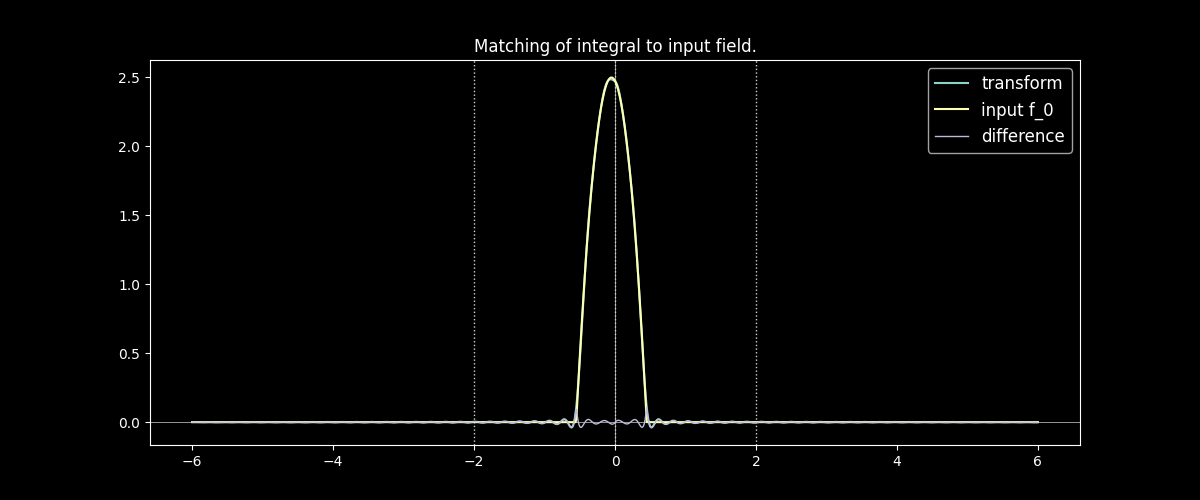

In [56]:
A.plot_field_1d(full, xs=fine_xs, part='real', label='transform');
A.add_1d_plot(f0, xs=fine_xs, label='input f_0')
A.add_1d_plot(diff, xs=fine_xs, label='difference', lw=1)
plt.title("Matching of integral to input field.")

Text(0.5, 1.0, 'Decomposition of input field into guided and radiation portions\n')

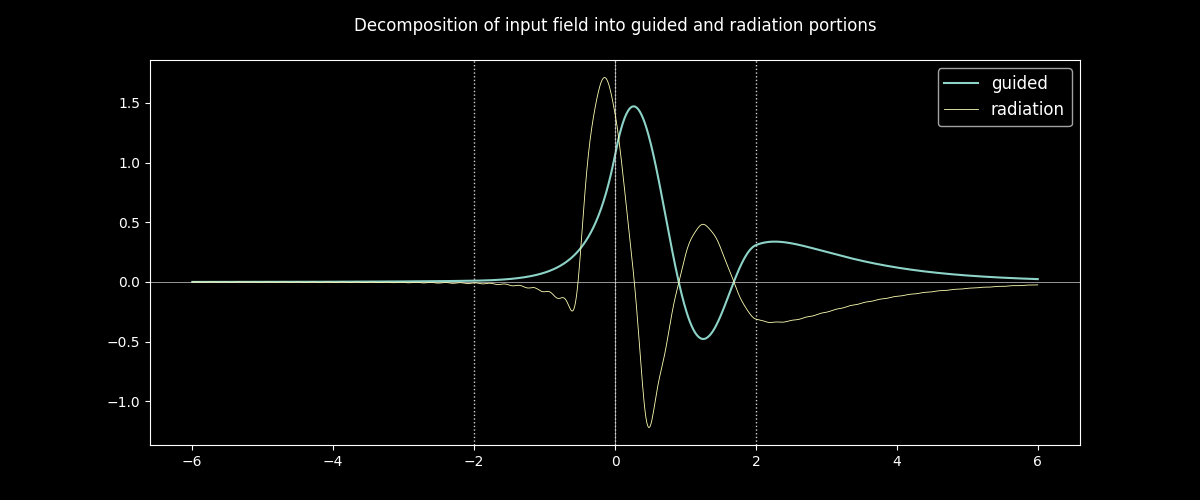

In [57]:
A.plot_field_1d(guided, xs=fine_xs, part='real', label='guided');
A.add_1d_plot(rad, xs=fine_xs, label='radiation', lw=.6)
# A.add_1d_plot(ev, xs=fine_xs, label='evanescent', lw=.6)
plt.title("Decomposition of input field into guided and radiation portions\n")

Text(0.5, 1.0, 'Decomposition of radiation field into propagating and evanescent portions')

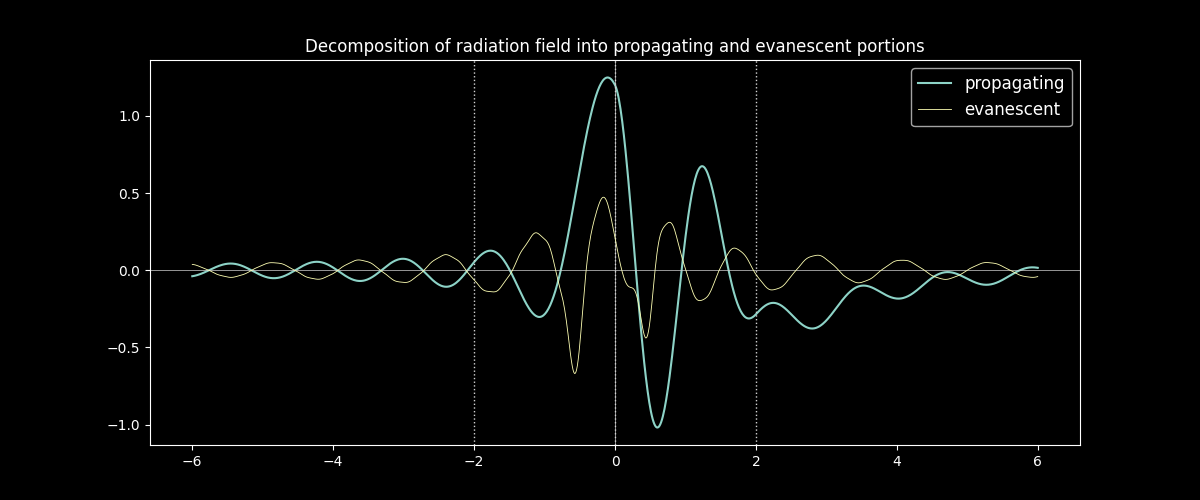

In [58]:
A.plot_field_1d(prop, xs=fine_xs, part='real', label='propagating');
A.add_1d_plot(ev, xs=fine_xs, label='evanescent', lw=.6)
plt.title("Decomposition of radiation field into propagating and evanescent portions")

# 2D Plots

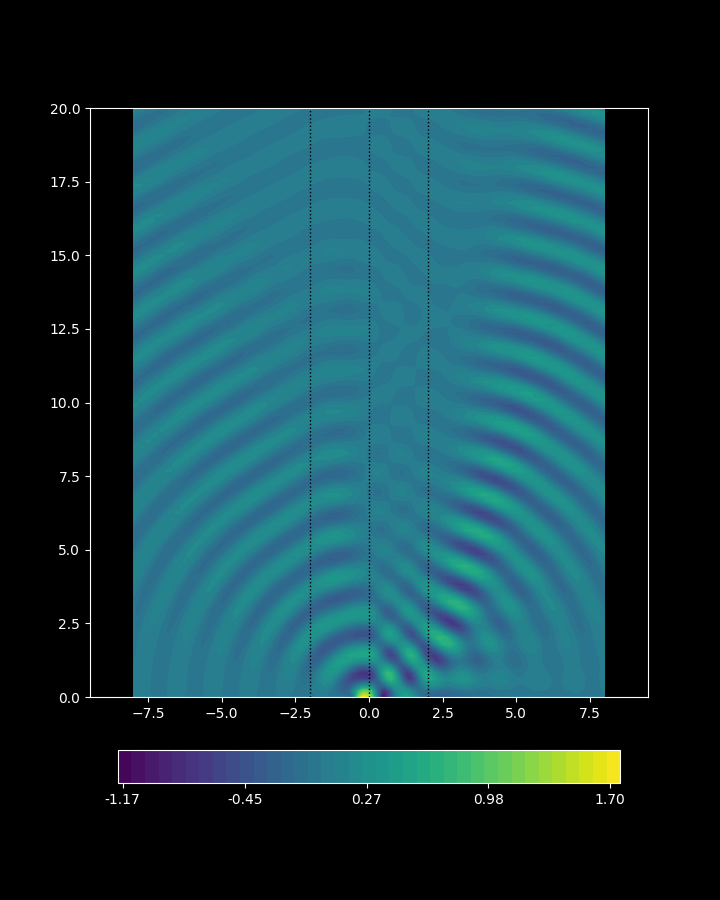

In [59]:
A.plot_field_2d(Rad, xs=mid_xs, zmin=0, zmax=20, zref=100)
plt.axis('equal');

(<Figure size 1000x500 with 1 Axes>, <Axes3D: >)

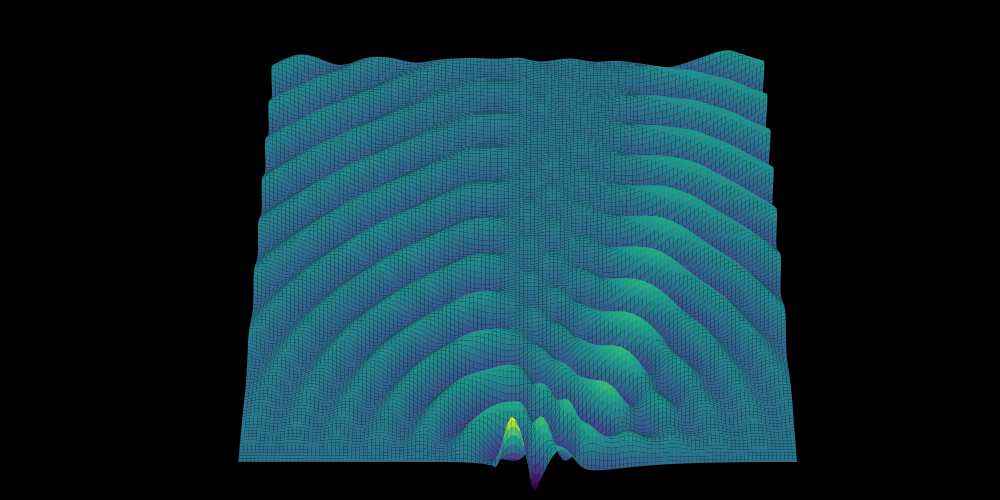

In [60]:
A.plot_field_2d_surface(Rad, xs=mid_xs, zmax=15, zref=150, rstride=1, cstride=1)

# Get leaky modes

(<Figure size 1100x500 with 2 Axes>, <Axes: >)

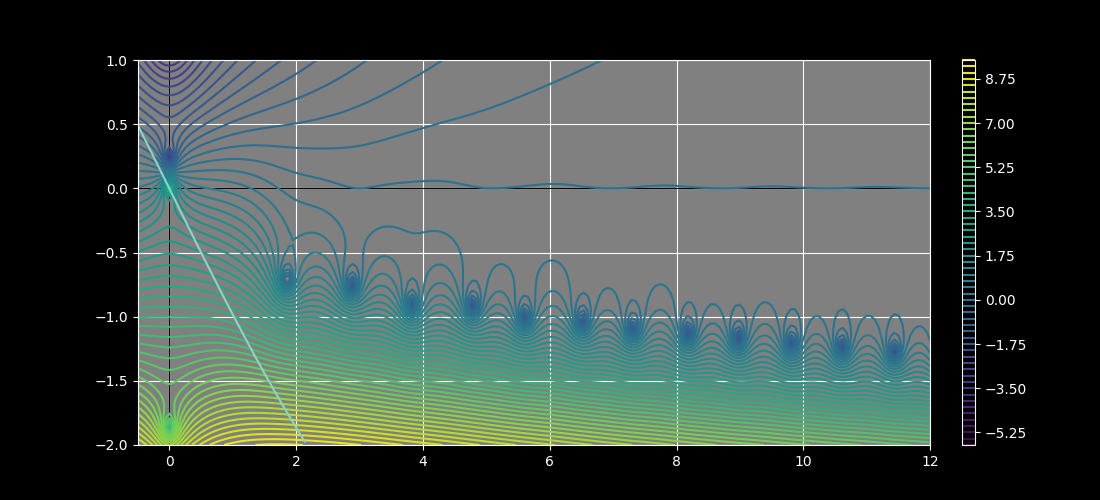

In [96]:
plt.close('all')
A.determinant_plot(-.5, 12, -2, 1)

In [97]:
guesses_leaky = np.array([2-.75j, 3 - .75j, 3.8-.9j, 4.8-.9j, 5.5-1j, 6.5-1j, 7.2-1j, 8-1.2j,
                         9-1.3j, 10-1.4j, 10.5-1.5j, 11.3-1.4j])
Zs_leaky = np.array([newton(A.determinant, guess)[0] for guess in guesses_leaky])
A.plot_points(Zs_leaky)

In [98]:
P_leaky = []
for Z in Zs_leaky:
    P_leaky_even = Propagator_Class(A.circular_contour(Z, .01, 6, orientation='cw'), f0=f0, Lx=Lx, Rx=Rx, sign=1,
                                   Normalizer=Eig)
    P_leaky_odd = Propagator_Class(A.circular_contour(Z, .01, 6, orientation='cw'), f0=f0, Lx=Lx, Rx=Rx, sign=-1,
                                  Normalizer=Eig)
    P_leaky.append(P_leaky_even)
    P_leaky.append(P_leaky_odd)

In [99]:
leaky = lambda x: sum([P.slice_propagate(x) for P in P_leaky])
Leaky = lambda x, z: sum([P.propagate(x, z) for P in P_leaky])

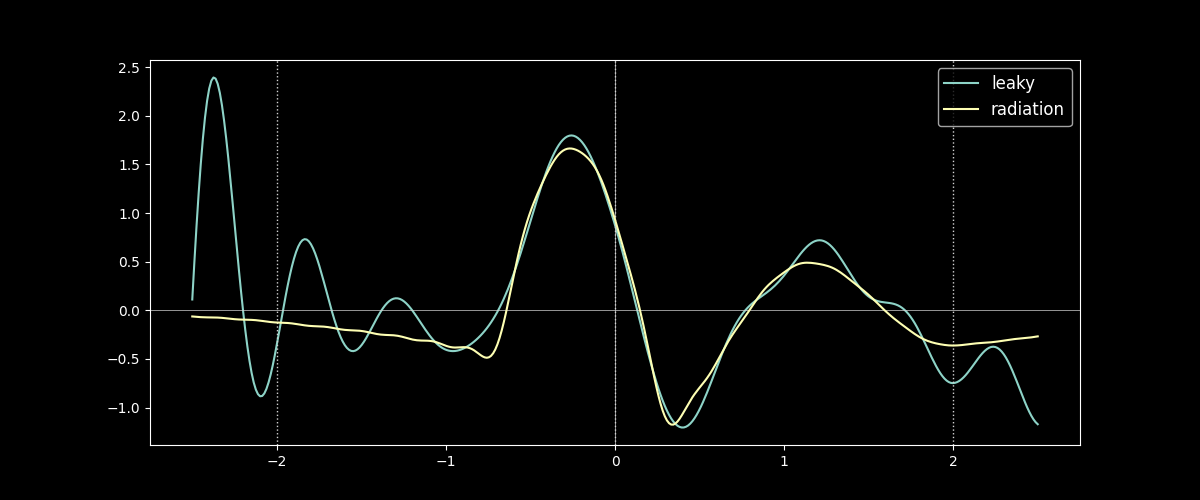

In [100]:
A.plot_field_1d(leaky, xs=np.linspace(-2.5, 2.5, 400), label='leaky')
A.add_1d_plot(rad, xs=np.linspace(-2.5, 2.5, 400), label='radiation')

(<Figure size 720x900 with 2 Axes>, <Axes: >)

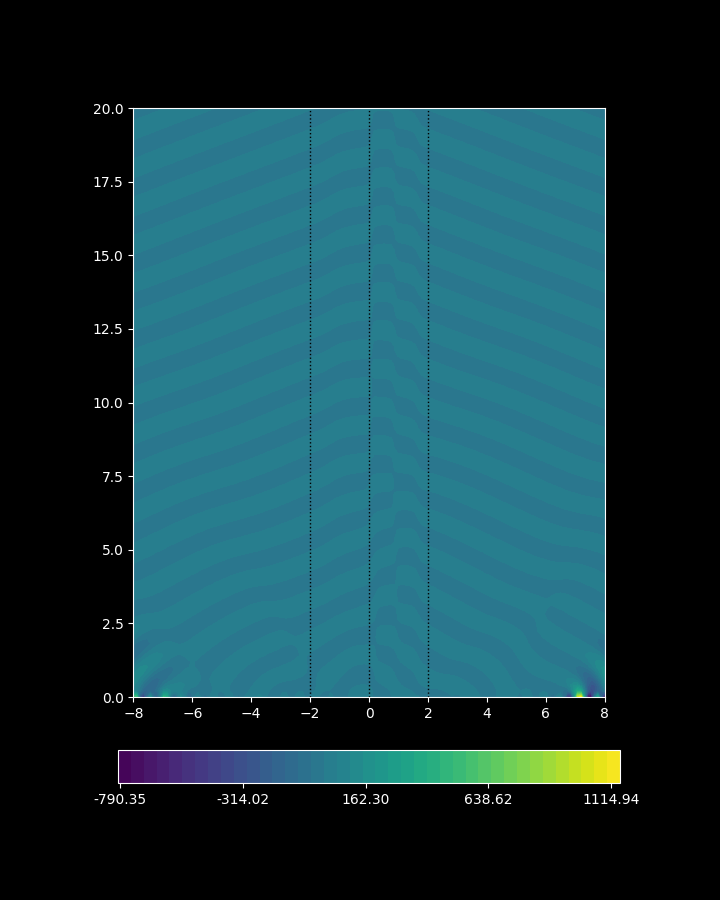

In [101]:
A.plot_field_2d(Leaky, xs=mid_xs, zmin=0, zmax=20, zref=100)

# Save data for visualization


In [309]:
xs = A.all_Xs
zs = np.linspace(0, 100, int(100*40/2))

In [310]:
f0s = f0(xs)

In [311]:
rad_ys_propagating = Prop(xs, zs)


NameError: name 'Prop' is not defined

In [507]:
rad_ys_evanescent = Ev(xs, zs)


In [508]:
# guided_ys = alpha * Fs1(xs, zs=zs)

In [509]:
Xs, Zs = np.meshgrid(xs, zs)

In [510]:
def get_trig_indices(mesh_array):
    '''Get triangle index list for three js mesh formation via indexed buffer geometry.'''
    if len(mesh_array.shape) <= 1:
        raise ValueError('Provide meshgrid array as input.')
    Nz, Nx = mesh_array.shape[0], mesh_array.shape[1]
    l_inds = Nx * Nz
    indices =  np.arange(0, l_inds).reshape((Nx, Nz)).T  # Note transpose
    fbases = indices[:Nz-1, :Nx-1].T.flatten()  # Note transpose and index switch due to transpose
    f1 = np.array([[i, i+Nz, i+1] for i in fbases], dtype=int)
    f2 = np.array([[i+1, i+Nz, i+Nz+1] for i in fbases], dtype=int)
    return np.concatenate((f1, f2))


def get_base_vertices(Xs, Zs):
    '''Get vertices of triangles with zero height (y component in three.js).'''
    if Xs.shape != Zs.shape:
        raise ValueError('Provide meshgrid arrays (ie Xs, Zs = np.meshgrid(xs,zs)) as inputs.')
    Base = np.array([Xs, np.zeros_like(Xs), Zs], dtype=float)
    L = Xs.shape[0] * Xs.shape[1]
    base_vertices = Base.T.reshape((L,3))
    return base_vertices


def create_height_array_from_complex(ys, Xs):
    '''Get data for height from complex ys input (needs to be formatted as list:
        [ys[0].real, ys[0].imag, ys[1].real, ys[1].imag, ... ].'''
    L = Xs.shape[0] * Xs.shape[1]
    Ys = np.array([ys.real, ys.imag], dtype=float)
    heights = Ys.T.reshape((L,2))
    return heights


def save_trig_indices_as_json(filepath, mesh_array):
    indices = get_trig_indices(mesh_array)
    with open(filepath + '.json', 'w') as outfile:
        json.dump(indices.flatten().tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)


def save_base_vertices_as_json(filepath, Xs, Zs):
    base_vertices = get_base_vertices(Xs, Zs)
    with open(filepath + '.json', 'w') as outfile:
        json.dump(base_vertices.flatten().tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)
        

def save_heights_as_json(filepath, ys, Xs):
    heights= create_height_array_from_complex(ys, Xs)
    with open(filepath + '.json', 'w') as outfile:
        json.dump(heights.flatten().tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)

def save_values_as_json(filepath, f0s):
    with open(filepath + '.json', 'w') as outfile:
        json.dump(f0s.tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)


In [511]:
prefix='/home/pv/local/slab/apps/hollow_core/'

In [512]:
save_trig_indices_as_json(prefix + 'trig_indices_new', Xs)

In [513]:
save_base_vertices_as_json(prefix + 'base_vertices_new', Xs, Zs)

In [514]:
# save_heights_as_json(prefix + 'guided_heights', guided_ys, Xs)

In [515]:
save_heights_as_json(prefix + 'evanescent_heights', rad_ys_evanescent, Xs)

In [516]:
save_heights_as_json(prefix + 'propagating_heights', rad_ys_propagating, Xs)

In [517]:
save_values_as_json(prefix + 'f0s', f0s)

In [518]:
save_values_as_json(prefix + 'x0s', xs)